# LELEC2910 - Project part II

This notebook serves as a tutorial for the **second part** of the project. It complements the detailed guidelines for the project that are available on Moodle.

In [24]:
# imports required
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skyfield.api import load, wgs84, EarthSatellite

import utils

## 1) RAPIDS software
RAPIDS II is a software developed by UCLouvain in the framework of an ESA contract in order to facilitate the analysis of Earth-space communications, namely by computing impairments due to the troposphere following ITU recommendations [[RAPIDS-II]](https://dial.uclouvain.be/pr/boreal/fr/object/boreal%3A145563). 

RAPIDS simulation outputs at 37.5 GHz are available on Moodle, for two different locations (Louvain-la-Neuve and another one assigned based on your group number). Please download those files and place them in the */rapids* folder. 

## 2) Reading RAPIDS outputs in Python - GEO statistics
The next step is to import RAPIDS-II calculations in this notebook and save them in pandas DataFrame format. As an example, the two `.csv` files for the total attenuation at 37.5 GHz are loaded in the next cell (one file is for the elevation angles $\theta = 5°,10°,...,50°$ and the other is for $\theta=55°,...,90°$). A plot is given as an example, and should compare with the graphs generated automatically by the RAPIDS software (available in the output files).

     SITE  SATELLITE  FREQUENCY  ELEVATION   EP  PROBABILITY  ATTENUATION
0       1          1       37.5        5.0  1.0        0.001    198.53000
1       1          1       37.5        5.0  1.0        0.002    180.06000
2       1          1       37.5        5.0  1.0        0.005    152.52000
3       1          1       37.5        5.0  1.0        0.008    138.02000
4       1          1       37.5        5.0  1.0        0.010    131.22000
..    ...        ...        ...        ...  ...          ...          ...
203     1          8       37.5       90.0  1.0       40.000      0.54805
204     1          8       37.5       90.0  1.0       55.000      0.46206
205     1          8       37.5       90.0  1.0       72.000      0.42515
206     1          8       37.5       90.0  1.0       90.000      0.40906
207     1          8       37.5       90.0  1.0       99.000      0.40447

[468 rows x 7 columns]


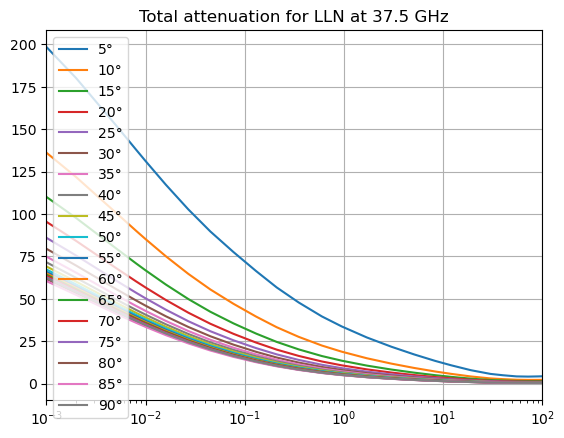

In [26]:
# Location of receiving Earth station
# Enter latitude [°], longitude [°] and altitude [m] of your ground station
ground_station = wgs84.latlon(50.67,4.61,160) # LLN for example

# Read files and generate pandas DataFrame
field_names = ["SITE","SATELLITE","FREQUENCY","ELEVATION","EP","PROBABILITY","ATTENUATION"] #depends on the type of file that is read! E.g. for total attenuation

file1 = pd.read_csv("rapids/lln_37GHz_1/output/ascii/attenuation_total.csv",skiprows=7,names=field_names)
file2 = pd.read_csv("rapids/lln_37GHz_2/output/ascii/attenuation_total.csv",skiprows=7,names=field_names)

rapids_data = pd.concat((file1,file2))

print(rapids_data)
utils.plot_RAPIDS_outputs(rapids_data,"Total attenuation for LLN at 37.5 GHz")


Using similar commands, you can read other `.csv` files from RAPIDS-II. Remember that, at this stage, all quantities are computed for a GEO satellite visible from your location, with the different elevation angles $\theta$.

## 3) Importing the trajectory of a LEO satellite
A record of most satellites orbiting the Earth can be found on the [CelesTrak](https://celestrak.org/) website. From this record, Python libraries, such as [Skyfield](https://rhodesmill.org/skyfield/), provide several tools useful to determine the position of Earth satellites.

The standard for referring to Earth-orbiting objects is the two-line element (TLE) file. It is usually a simple `.txt` file containing the name of the object, as well as several numbers giving the object's position as well as information to predict the evolution of its orbit. As an example, the TLE for the International Space Station (ISS) is:

> ISS (ZARYA)
>
> 1 25544U 98067A   08264.51782528 -.00002182  00000-0 -11606-4 0  2927
>
> 2 25544  51.6416 247.4627 0006703 130.5360 325.0288 15.72125391563537

The meaning of the different fields can be found on this [Wikipedia page](https://en.wikipedia.org/wiki/Two-line_element_set), and is not of interest of the project. Simply remember that by providing the TLE file of a satellite to Skyfield, you can predict its position around Earth at any time (Skyfield makes use of the SGP4 satellite propagation routine).

### Loading a TLE file from CelesTrak website
You can directly donwload and cache a file full of satellite elements from CelesTrak website using the `tle_file()` method from Skyfield (see documentation available at [https://rhodesmill.org/skyfield/earth-satellites.html](https://rhodesmill.org/skyfield/earth-satellites.html)). As an example, the following code load all weather satellites tracked by the NORAD:

In [41]:
satellite_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
satellites = load.tle_file(satellite_url, reload=False)

by_name = {sat.name: sat for sat in satellites}
satellite = by_name['HST'] # find METOP-C satellite

print(satellite)

HST catalog #20580 epoch 2024-11-27 16:20:13 UTC


You can now access to [https://celestrak.org/NORAD/elements/](https://celestrak.org/NORAD/elements/) and choose your favorite satellite or constellation. Then, save the url of the TLE file and use it in the cell above. Alternatively, you can import only the TLE information of your satellite of interest in the cell below:

In [37]:
ts = load.timescale()
line1 = '1 38771U 12049A   22236.12724981  .00000025  00000+0  31524-4 0  9996'
line2 = '2 38771  98.6908 294.8618 0000960 136.5745 276.7396 14.21502770515349'

satellite = EarthSatellite(line1, line2, 'METOP-B', ts)

print(satellite)

METOP-B catalog #38771 epoch 2022-08-24 03:03:14 UTC


### Computation of satellite trajectory
To obtain the satellite position at a given time, use the `satellite.at()` method. For example:

In [49]:
t = ts.utc(2022, 9, 18, 18, 35, 0) # 18/09/2022, at 18:35:00 UTC. You can instead use ts.now() for the current time

geocentric = satellite.at(t)
print(geocentric.position.km) #satellite position in Geocentric Celestial Reference System (GCRS)


lat, lon = wgs84.latlon_of(geocentric) #satellite position in latitude, longitude
print('Latitude:', lat.dstr(format=u'{0}{1}°{2:02}′{3:02}.{4:0{5}}″'))
print('Longitude:', lon.dstr(format=u'{0}{1}°{2:02}′{3:02}.{4:0{5}}″'))

[6077.64039887 2887.26909472 1653.99905167]
Latitude: 14°00′25.4″
Longitude: 109°18′11.3″


However, what we are mostly interested in is to determine whether the satellite is above or below the horizon from the ground station position (i.e. whether the satellite is visible), and in which direction to look for it. This can be achieved by subtracting the satellite position and the ground station position, and evaluating the relative position at time $t$. Then, the elevation and azimuth angles at which the satellite can be seen from the ground station can be computed, as well as the distance between them. You can find more information at the following link: [[https://rhodesmill.org/skyfield/earth-satellites.html]](https://rhodesmill.org/skyfield/earth-satellites.html), in the section about **Satellite altitude, azimuth and distance**.

In [ ]:
# Relative position between satellite and ground station
relative_position = satellite - ground_station

# TO DO: determine if the satellite you have chosen is visible at time t (as defined above) from your ground station

# ...
# ...
# ...


## 4) Conversion from GEO to LEO statistics and link budget
Now, you have access to all necessary information to work on the project. Based on RAPIDS outputs and your satellite position, you are asked to obtain the attenuation statistics for this satellite. A change of GEO statistics (as outputed by RAPIDS) to LEO statistics is required, and is achieved thanks to the conditional probability relation:

\begin{equation}
P(A>A_0) = \sum_{\theta} P(A>A_0 | \theta) P(\theta),
\end{equation}

where $P(\theta)$ is the probability occurrence of the LEO satellite at elevation angle $\theta$, and $P(A>A_0 | \theta)$ is the probability of exceeded attenuation for a given elevation angle $\theta$, corresponding to the GEO-statistics from RAPIDS-II output (extracted in Section 2). More information can be found in the ITU recommendation referenced in the project statement as well as in the extra material available on Moodle.

Finally, using $P(A>A_0)$, the link budget for different times exceed of the availability can be computed. Use the parameters from the project statement.
